# Hypotheses

**If add maybe work well**
- add distance between airports
- add meteo
- add holidays for from ans to
- mean ticket prices 24h before, avrage before

# Librairies

In [153]:
import numpy as np
import seaborn as sns
import requests
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.decomposition import PCA
from sklearn import set_config
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pandas_profiling import ProfileReport
pd.set_option('display.max_columns', None)
%matplotlib inline

# Read Data

In [2]:
# Original Dataset
df = pd.read_csv('./data/flights_train.csv.bz2')
df_sub = pd.read_csv('./data/flights_Xtest.csv.bz2')

In [3]:
df['flight_date'] = pd.to_datetime(df['flight_date'])
df_sub['flight_date'] = pd.to_datetime(df_sub['flight_date'])

# Utils

### APIs

In [4]:
""" the Metadata API"""

from joblib import Memory
location = './cachedir'
memory = Memory(location, verbose=0)

headers = {'x-rapidapi-host': "airport-info.p.rapidapi.com",
           'x-rapidapi-key': "670c14cef2mshc0f539c8f496dbcp19f4cejsn7e4b16db61a9"}

def metadata_airport(code):
    """
    we get meta data for each airport
    """
    url = "https://airport-info.p.rapidapi.com/airport"
    querystring = {"iata" : code, "icao" : code}
    response = requests.request("GET", url, headers=headers, params=querystring)
#     print(response.text)
    response = dict(eval(response.text))
    
    return pd.Series([response["latitude"], response["longitude"], response["country"], response["city"]])

metadata_airport = memory.cache(metadata_airport)

metadata_airport('CMN')

0    33.371754
1    -7.587027
2      Morocco
3     Nouaceur
dtype: object

the use of joblib librairie to accelerate the processe pf data collection also because of limited number of requests we can do on the API

In [5]:
# df['from_city'] = df['from'].apply(metadata_airport)
# df['to_city'] = df['to'].apply(metadata_airport)

In [6]:
# df_sub['from_city'] = df_sub['from'].apply(metadata_airport)
# df_sub['to_city'] = df_sub['to'].apply(metadata_airport)

In [7]:
# df[['from_latitude', 'from_longitude', 'from_country']] = df['from'].apply(metadata_airport)
# df[['to_latitude', 'to_longitude', 'to_country']] = df['to'].apply(metadata_airport)

In [8]:
# df_sub[['from_latitude', 'from_longitude', 'from_country']] = df_sub['from'].apply(metadata_airport)
# df_sub[['to_latitude', 'to_longitude', 'to_country']] = df_sub['to'].apply(metadata_airport)

In [9]:
""" Holydays API """
location = './cachedir'
memory = Memory(location, verbose=0)

headers = {
    'x-rapidapi-host': "public-holiday.p.rapidapi.com",
    'x-rapidapi-key': "670c14cef2mshc0f539c8f496dbcp19f4cejsn7e4b16db61a9"
    }

def get_holidays(year):
    
    url = "https://public-holiday.p.rapidapi.com/"+ str(year) + "/US"
    response = requests.request("GET", url, headers=headers)

    response = response.json()
    return response
    
get_holidays = memory.cache(get_holidays)

response_2011 = get_holidays(2011)
holidays_2011 = [response_2011[i]['date'] for i in range(len(response_2011))]

response_2012 = get_holidays(2012)
holidays_2012 = [response_2012[i]['date'] for i in range(len(response_2012))]

response_2013 = get_holidays(2013)
holidays_2013 = [response_2013[i]['date'] for i in range(len(response_2013))]

holidays = holidays_2011 + holidays_2012 + holidays_2013
print(holidays)

['2010-12-31', '2011-01-17', '2011-02-21', '2011-04-22', '2011-04-22', '2011-05-30', '2011-07-04', '2011-09-05', '2011-10-10', '2011-11-11', '2011-11-24', '2011-12-26', '2012-01-02', '2012-01-16', '2012-02-20', '2012-04-06', '2012-04-06', '2012-05-28', '2012-07-04', '2012-09-03', '2012-10-08', '2012-11-12', '2012-11-22', '2012-12-25', '2013-01-01', '2013-01-20', '2013-01-21', '2013-02-18', '2013-03-29', '2013-03-29', '2013-05-27', '2013-07-04', '2013-09-02', '2013-10-14', '2013-11-11', '2013-11-28', '2013-12-25']


### function that calculate the distance between cities

In [10]:
import geopy.distance
def calculate_distance(l1, L1, l2, L2):
    coords_1 = (l1, L1)
    coords_2 = (l2, L2)
    return geopy.distance.distance(coords_1, coords_2).km

### Blending Models

In [11]:
def blender(models):
    return np.mean(models, axis=0)

# Data descripton

In [12]:
# df = df.set_index('flight_date')
# df = df.sort_index()

In [13]:
df.head()

,flight_date,from,to,avg_weeks,target,std_weeks
0,2012-06-19,ORD,DFW,12.875000,12.331296,9.812647
1,2012-09-10,LAS,DEN,14.285714,10.775182,9.466734
2,2012-10-05,DEN,LAX,10.863636,11.083177,9.035883
3,2011-10-09,ATL,ORD,11.480000,11.169268,7.990202
4,2012-02-21,DEN,SFO,11.450000,11.269364,9.517159


<AxesSubplot:xlabel='target'>

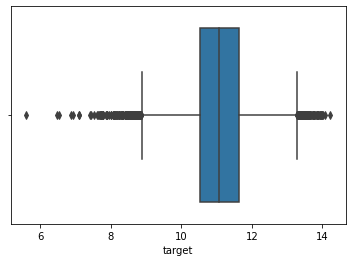

In [14]:
sns.boxplot(x=df.target)

In [15]:
# Fill null values using interpolation
df.loc[df.target < 7.25, 'target'] = np.nan
df.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

In [16]:
df.describe()

,avg_weeks,target,std_weeks
count,8896.000000,8896.000000,8896.000000
mean,11.580564,11.082507,8.648275
std,2.726443,0.941194,2.045742
min,2.625000,7.404498,2.160247
25%,9.722222,10.533779,7.216347
50%,11.447222,11.063493,8.597628
75%,13.320000,11.630678,10.079555
max,22.372093,14.224277,14.958061


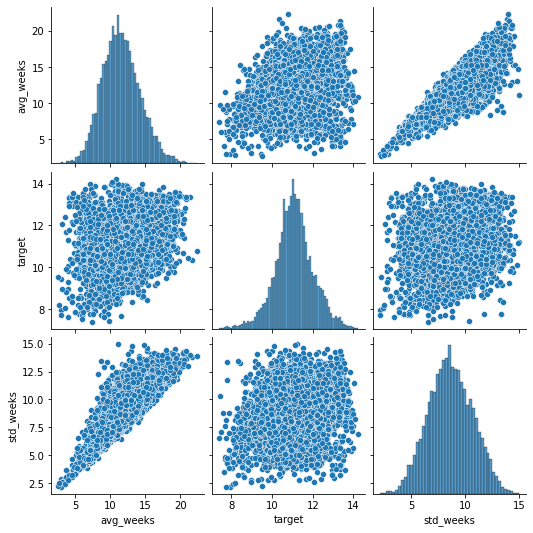

In [17]:
sns.pairplot(df)

<AxesSubplot:>

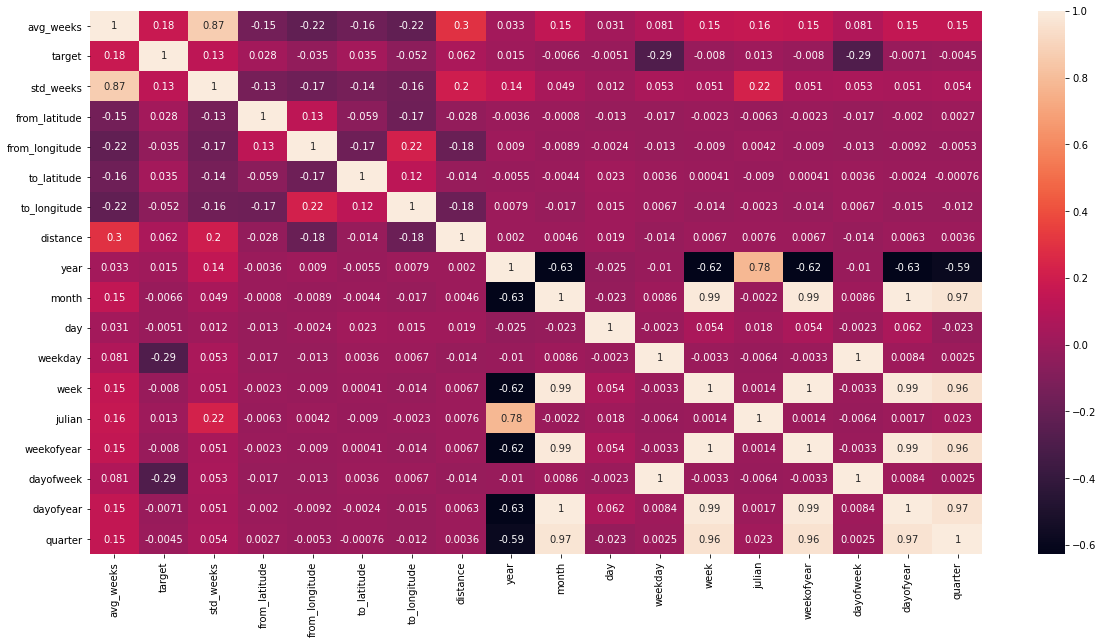

In [218]:
fig = plt.figure(figsize=(20, 10))
sns.heatmap(df.corr(), annot=True)

In [19]:
target = np.unique(df[['from', 'to']].values.astype(str), axis=0)

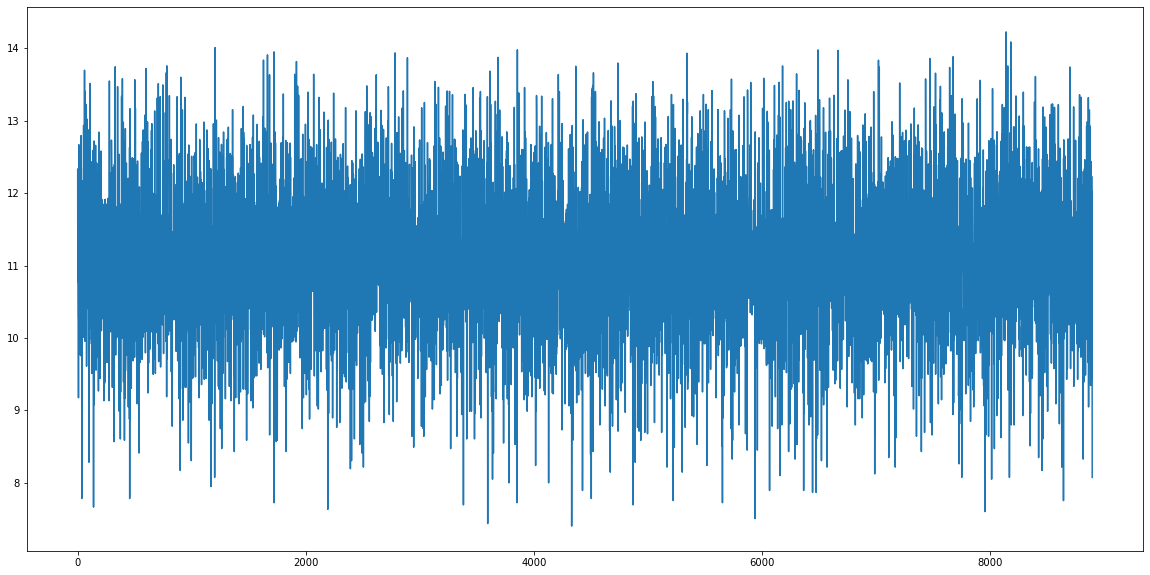

In [20]:
fig = plt.figure(figsize=(20, 10))
plt.plot(df['target'])
plt.show()

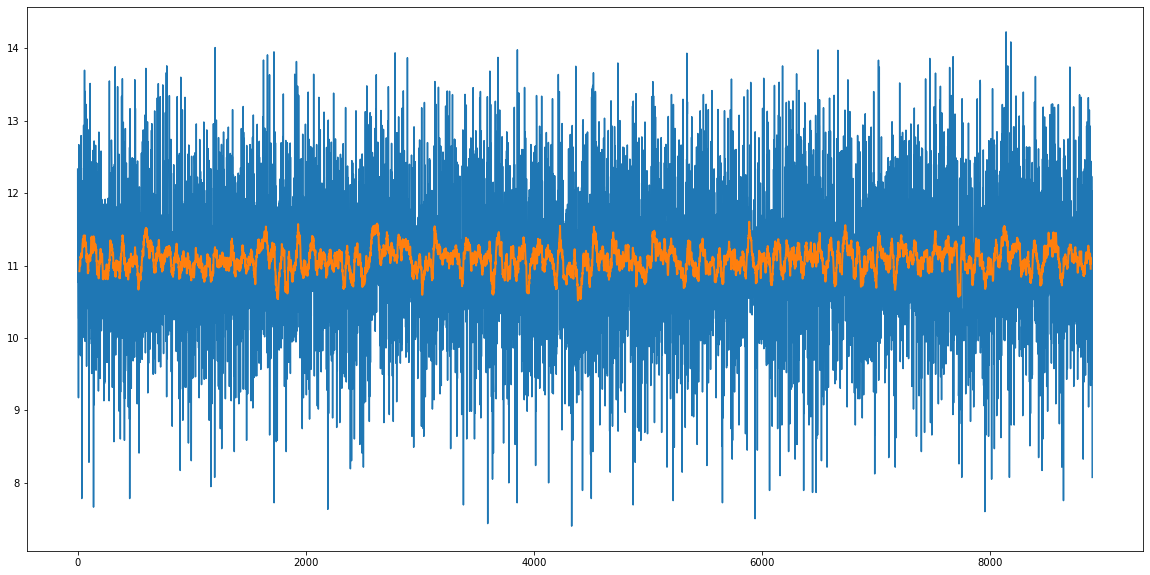

In [21]:
# Plot the hourly actual electricity price, along with the weekly rolling mean
fig = plt.figure(figsize=(20, 10))
rolling = df['target'].rolling(30, center=True).mean()
plt.plot(df['target'])
plt.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')
plt.show()

In [22]:
grouped_df = pd.DataFrame(df.groupby(by=df.index).mean().reset_index())

In [23]:
# grouped_df = grouped_df.set_index('flight_date')
# grouped_df = grouped_df.sort_index()
# grouped_df

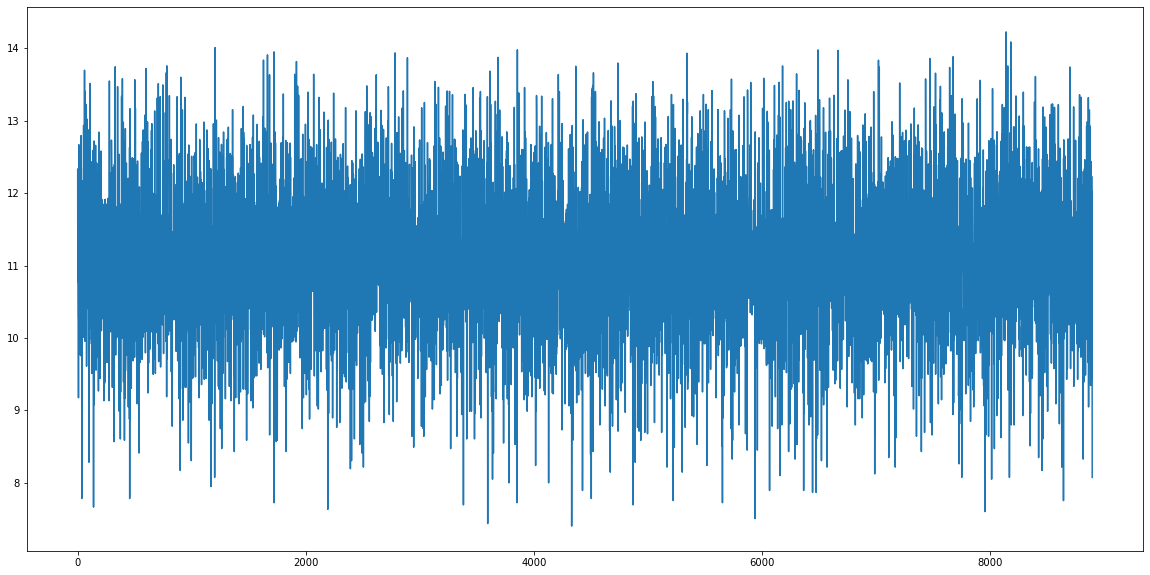

In [24]:
fig = plt.figure(figsize=(20, 10))
plt.plot(grouped_df['target'])
plt.show()

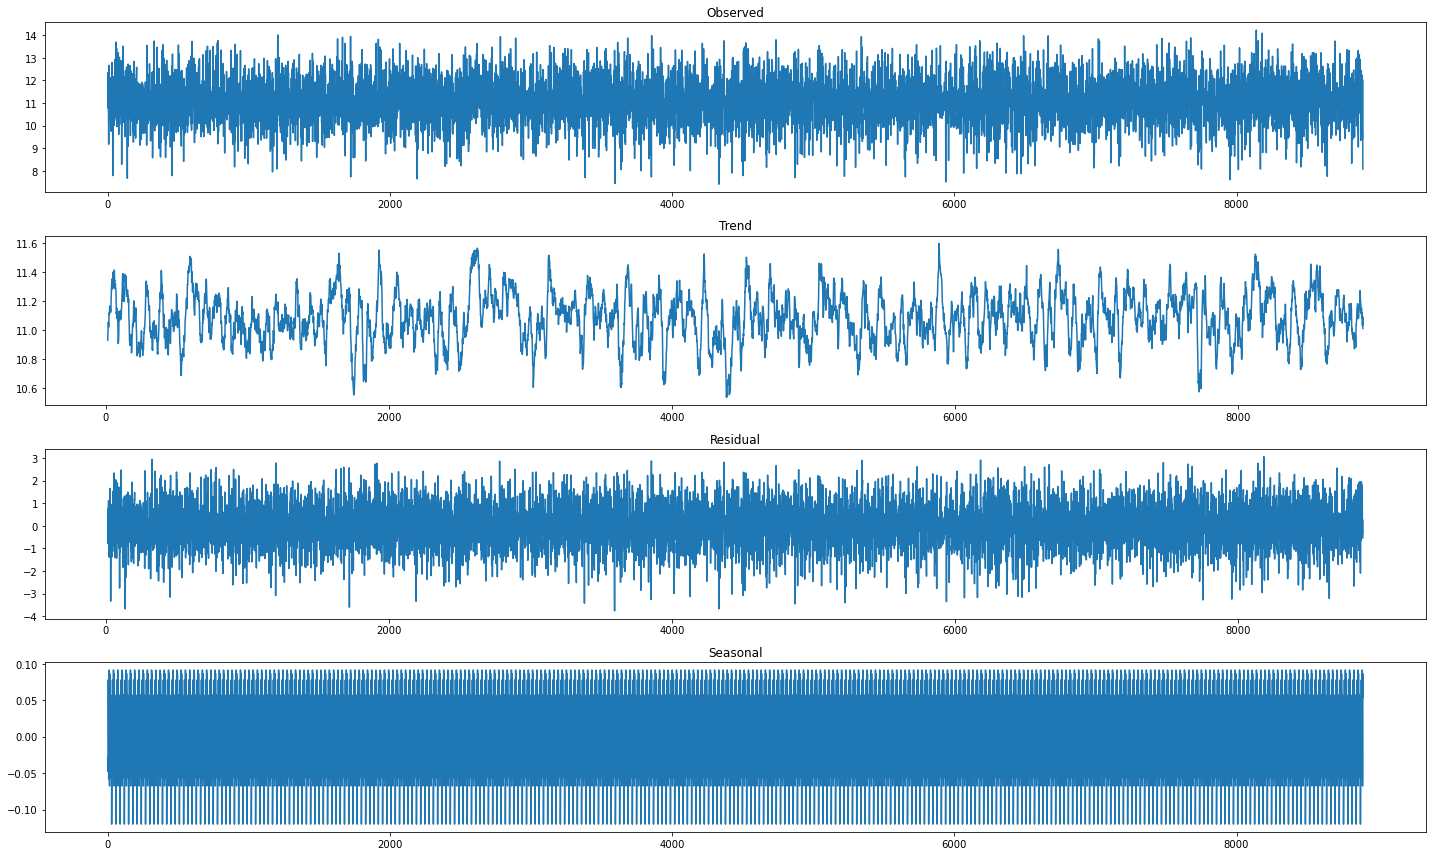

In [25]:
# Decompose the electricity price time series

res = sm.tsa.seasonal_decompose(x=df['target'], model='additive', period=30)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
res.observed.plot(ax=ax1, title='Observed')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
res.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()

The **Augmented Dickey-Fuller (ADF) test**, a type of unit root test, determines how strongly a time series is defined by a trend. Its hypotheses are the following:
- **Null Hypothesis** $H_{0}$: There is a unit root in the time series, i.e. the series is autocorrelated with (r=1), a time dependent structure and thus, is not stationary.
- **Alternate Hypothesis** $H_{1}$: The time series has no unit root and is either stationary or can be made stationary using differencing.

In [26]:
y = df['target']
adf_test = adfuller(y, regression='c')
print('ADF Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(adf_test[0], adf_test[1], adf_test[2]))
for key, value in adf_test[4].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

ADF Statistic: -95.364245
p-value: 0.000000
#Lags used: 0
Critical Value (1%): -3.431085
Critical Value (5%): -2.861865
Critical Value (10%): -2.566943


The ADF statistic (-9.147) is less than the critical value at 1% (-3.431) and thus, we can say that **we reject the null hypothesis $H_{0}$ with a significance level 1%**, meaning that there is not a root-unit in the time series and thus, that it is either stationary or could be made stationary with 1st order differencing (difference-stationary).

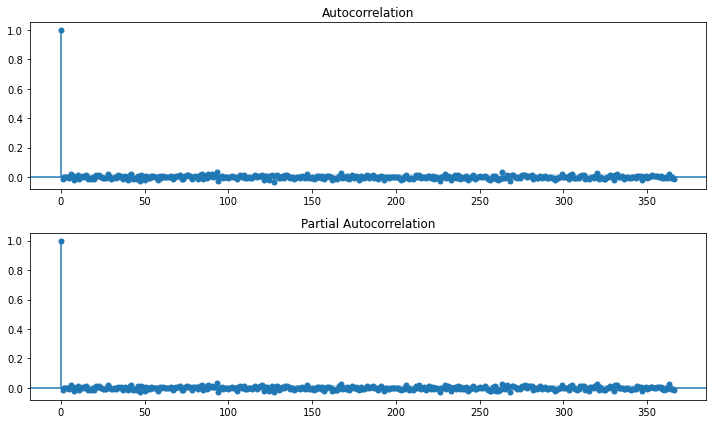

In [27]:
# Plot autocorrelation and partial autocorrelation plots

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(df['target'], lags=366, ax=ax1)
plot_pacf(df['target'], lags=366, ax=ax2)
plt.tight_layout()
plt.show()

The partial autocorrelation plot of target time series shows that the direct relationship between an observation at a given day (t) is strongest with the observations at t-1, t-2, t-135 to t-150 time-steps and diminishes afterwards. Thus, we are going to use the 150 previous values of each time series which will constitute a feature for our models. 

Nevertheless, it would quite definitely be more beneficial if we only chose to use specific past values (observations at certain time-lags) of a given feature, based on the cross-correlation between the target and each one of the features in the dataset. For example, below we can see the cross-correlation between the target and the avg_weeks. We see that there are many time-lags with a correlation which is close to zero and could be ommited. 

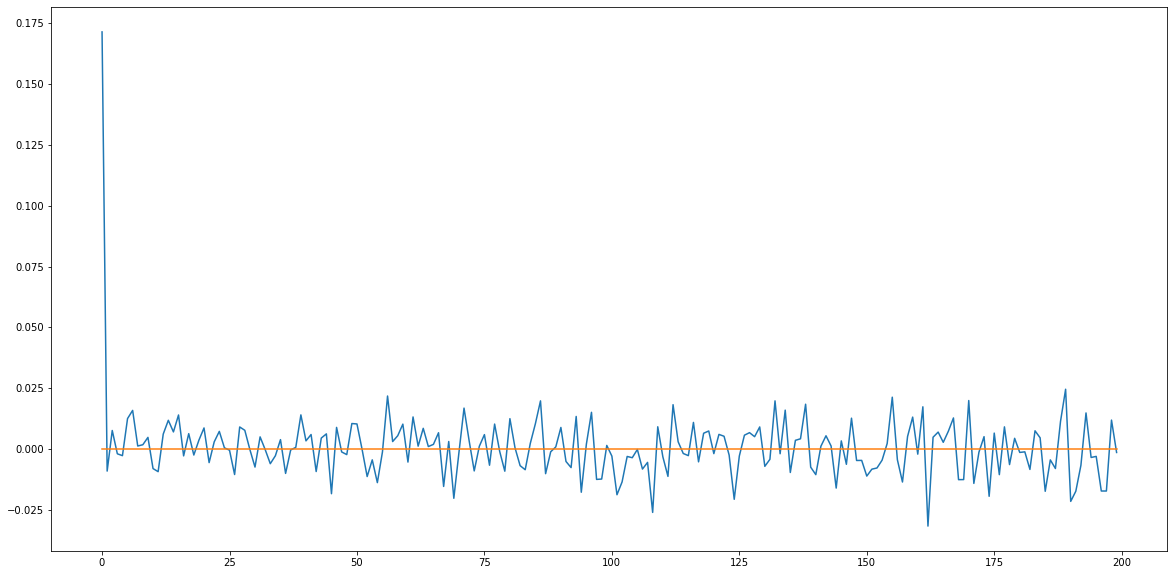

In [28]:
fig = plt.figure(figsize=(20, 10))
cross_corr = ccf(df['avg_weeks'], df['target'])
plt.plot(cross_corr[0:200])
plt.plot(np.zeros(200))
plt.show()

- target variable is symetric 
- there is no hard correlation between target and other dependent variable.

we need to add meta data, first thing add coordinate for each eaiport, to determine the distance between airports because the price of a flight ticket correlate with the distance, and costumers tend to not let go expensive flight tickets

**the new data is collected thanks to an api that get airports infos**

In [29]:
df = pd.read_csv('./data/train_with_coor.csv')
df_sub = pd.read_csv('./data/test_with_coor.csv')

In [30]:
df.head()

,flight_date,from,to,avg_weeks,target,std_weeks,from_latitude,from_longitude,from_country,to_latitude,to_longitude,to_country
0,2012-06-19,ORD,DFW,12.875000,12.331296,9.812647,41.974163,-87.907320,United States,32.899810,-97.04034,United States
1,2012-09-10,LAS,DEN,14.285714,10.775182,9.466734,36.084000,-115.153740,United States,39.856100,-104.67374,United States
2,2012-10-05,DEN,LAX,10.863636,11.083177,9.035883,39.856100,-104.673740,United States,33.941590,-118.40853,United States
3,2011-10-09,ATL,ORD,11.480000,11.169268,7.990202,33.640728,-84.427704,United States,41.974163,-87.90732,United States
4,2012-02-21,DEN,SFO,11.450000,11.269364,9.517159,39.856100,-104.673740,United States,37.621310,-122.37895,United States


In [31]:
print("the unique values of the from country", df['from_country'].value_counts())
print("the unique values of the to country", df['to_country'].value_counts())

the unique values of the from country United States    8896
Name: from_country, dtype: int64
the unique values of the to country United States    8896
Name: to_country, dtype: int64


- All the flights from and to are domestic ones
- we should drop from_country and to_country because they have one unique value
- Also we are going to calculate the distance between cities using coordinates

In [32]:
# df = df.drop(['from_country', 'to_country'], axis=1)
# df_sub = df_sub.drop(['from_country', 'to_country'], axis=1)

In [33]:
# df['distance'] = np.vectorize(calculate_distance)(df['from_latitude'], df['from_longitude'], df['to_latitude'], df['to_longitude'])
# df_sub['distance'] = np.vectorize(calculate_distance)(df_sub['from_latitude'], df_sub['from_longitude'], df_sub['to_latitude'], df_sub['to_longitude'])

In order to save time while execution, we execute the code above one time and then we save the date set to get a new data set

In [294]:
df = pd.read_csv('./data/train_with_city.csv', parse_dates=['flight_date'])
df_sub = pd.read_csv('./data/test_with_city.csv', parse_dates=['flight_date'])

In [295]:
df = df.drop(['from_city', 'to_city'], axis=1)
df_sub = df_sub.drop(['from_city', 'to_city'], axis=1)

In [296]:
df['year'] = pd.DatetimeIndex(df['flight_date']).year
df_sub['year'] = pd.DatetimeIndex(df_sub['flight_date']).year

df['month'] = pd.DatetimeIndex(df['flight_date']).month
df_sub['month'] = pd.DatetimeIndex(df_sub['flight_date']).month

df['day'] = pd.DatetimeIndex(df['flight_date']).day
df_sub['day'] = pd.DatetimeIndex(df_sub['flight_date']).day

df['dayofweek'] = pd.DatetimeIndex(df['flight_date']).dayofweek
df_sub['dayofweek'] = pd.DatetimeIndex(df_sub['flight_date']).dayofweek

df['week'] = df['flight_date'].dt.isocalendar().week.astype(int)
df_sub['week'] = df_sub['flight_date'].dt.isocalendar().week.astype(int)

In [297]:
df

,flight_date,from,to,avg_weeks,target,std_weeks,from_latitude,from_longitude,to_latitude,to_longitude,distance,year,month,day,dayofweek,week
0,2012-06-19,ORD,DFW,12.875000,12.331296,9.812647,41.974163,-87.907320,32.899810,-97.040340,1289.698532,2012,6,19,1,25
1,2012-09-10,LAS,DEN,14.285714,10.775182,9.466734,36.084000,-115.153740,39.856100,-104.673740,1010.700812,2012,9,10,0,37
2,2012-10-05,DEN,LAX,10.863636,11.083177,9.035883,39.856100,-104.673740,33.941590,-118.408530,1386.808962,2012,10,5,4,40
3,2011-10-09,ATL,ORD,11.480000,11.169268,7.990202,33.640728,-84.427704,41.974163,-87.907320,974.145965,2011,10,9,6,40
4,2012-02-21,DEN,SFO,11.450000,11.269364,9.517159,39.856100,-104.673740,37.621310,-122.378950,1556.562600,2012,2,21,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8891,2011-11-24,DEN,PHX,11.045455,9.795363,7.791798,39.856100,-104.673740,33.437267,-112.007790,967.511116,2011,11,24,3,47
8892,2012-09-01,ATL,DEN,11.000000,9.429776,7.937254,33.640728,-84.427704,39.856100,-104.673740,1929.754252,2012,9,1,5,35
8893,2012-08-10,ORD,EWR,9.476190,12.029971,6.903760,41.974163,-87.907320,40.689533,-74.174460,1157.147451,2012,8,10,4,32
8894,2012-07-03,ORD,IAH,10.250000,9.381645,7.107261,41.974163,-87.907320,29.990220,-95.336784,1487.504532,2012,7,3,1,27


In [298]:
df['julian'] = (df['flight_date'] - pd.to_datetime("2000-01-01")).dt.days
df_sub['julian'] = (df_sub['flight_date'] - pd.to_datetime("2000-01-01")).dt.days

In [299]:
df['path'] = df['from'] + "_" + df['to']
df_sub['path'] = df_sub['from'] + "_" + df_sub['to']

In [300]:
unique_iata = df['from'].unique()
unique_iata_sub = df['from'].unique()

In [301]:
# for iata in unique_iata:
#     df[iata] = 0

# for ind in range(df.shape[0]):
#     FROM = df['from'][ind]
#     TO = df['to'][ind]
#     df[FROM][ind] = 1
#     df[TO][ind] = 2

In [302]:
# for iata in unique_iata_sub:
#     df_sub[iata] = 0

# for ind in range(df_sub.shape[0]):
#     FROM = df_sub['from'][ind]
#     TO = df_sub['to'][ind]
#     df_sub[FROM][ind] = 1
#     df_sub[TO][ind] = 2

In [303]:
# Fill null values using interpolation
# df.loc[df.target < 7.25, 'target'] = np.nan
# df.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

In [304]:
df.describe()

,avg_weeks,target,std_weeks,from_latitude,from_longitude,to_latitude,to_longitude,distance,year,month,day,dayofweek,week,julian
count,8896.000000,8896.000000,8896.000000,8896.000000,8896.000000,8896.000000,8896.000000,8896.000000,8896.000000,8896.00000,8896.000000,8896.000000,8896.000000,8896.000000
mean,11.580564,11.079129,8.648275,37.833930,-93.689316,37.729866,-93.592676,1722.118916,2011.715378,7.11893,15.549798,2.979317,29.111286,4479.623876
std,2.726443,0.949174,2.045742,4.660864,17.412678,4.717283,17.510755,1086.945980,0.451260,3.39818,8.859036,2.001073,14.735326,128.275283
min,2.625000,5.586968,2.160247,25.795864,-122.378950,25.795864,-122.378950,296.970015,2011.000000,1.00000,1.000000,0.000000,1.000000,4261.000000
25%,9.722222,10.528622,7.216347,33.640728,-112.007790,33.640728,-112.007790,974.145965,2011.000000,4.00000,8.000000,1.000000,16.000000,4368.000000
50%,11.447222,11.063493,8.597628,39.856100,-87.907320,39.856100,-87.907320,1429.504256,2012.000000,8.00000,16.000000,3.000000,33.000000,4478.000000
75%,13.320000,11.630678,10.079555,41.974163,-80.287050,41.974163,-80.287050,2234.974856,2012.000000,10.00000,23.000000,5.000000,42.000000,4591.000000
max,22.372093,14.224277,14.958061,47.450250,-71.009560,47.450250,-71.009560,4351.692964,2012.000000,12.00000,31.000000,6.000000,52.000000,4701.000000


Now we are going to add average flight price from the origine

**the data is collected from us Dasaset**

In [305]:
fare_2011 = pd.read_excel('./data/AverageFareAnnual2011.xlsx')
fare_2012 = pd.read_excel('./data/AverageFareAnnual2012.xlsx')
fare_2013 = pd.read_excel('./data/AverageFareAnnual2013.xlsx')

fare_2011['year'] = 2011
fare_2012['year'] = 2012
fare_2013['year'] = 2013

In [306]:
# lets concatenat the two datasets after we are going to merge if with the initial dataset
concatenated_data = pd.concat([fare_2011, fare_2012, fare_2013])
concatenated_data = concatenated_data.reset_index()
concatenated_data

,index,2020 Passenger Rank,Airport Code,City Name,State Name,Average Fare ($),Inflation Adjusted Average Fare ($) (Base Year: 2021),year
0,0,1,LAX,Los Angeles,CA,394.88,467.38,2011
1,1,2,ATL,Atlanta,GA,368.74,436.44,2011
2,2,3,DEN,Denver,CO,319.57,378.24,2011
3,3,4,ORD,Chicago-O'Hare,IL,378.78,448.32,2011
4,4,5,DFW,Dallas-DFW,TX,417.41,494.05,2011
...,...,...,...,...,...,...,...,...
1360,447,422,SPB,Charlotte Amalie,VI,274.00,313.14,2013
1361,448,422,SVC,Silver City/Hurley,NM,518.62,592.71,2013
1362,449,422,VIS,Visalia,CA,403.02,460.59,2013
1363,450,422,WRL,Worland,WY,619.58,708.09,2013


In [307]:
merged_df = df.merge(concatenated_data, left_on=['from', 'year'], right_on=['Airport Code', 'year'], how='left')
merged_df_sub = df_sub.merge(concatenated_data, left_on=['from', 'year'], right_on=['Airport Code', 'year'], how='left')

In [308]:
merged_df = merged_df.drop(['index', 'Airport Code', 'City Name', 'State Name', '2020 Passenger Rank'], axis=1)
merged_df_sub = merged_df_sub.drop(['index', 'Airport Code', 'City Name', 'State Name', '2020 Passenger Rank'], axis=1)

In [309]:
merged_df.head()

,flight_date,from,to,avg_weeks,target,std_weeks,from_latitude,from_longitude,to_latitude,to_longitude,distance,year,month,day,dayofweek,week,julian,path,Average Fare ($),Inflation Adjusted Average Fare ($) (Base Year: 2021)
0,2012-06-19,ORD,DFW,12.875000,12.331296,9.812647,41.974163,-87.907320,32.899810,-97.04034,1289.698532,2012,6,19,1,25,4553,ORD_DFW,385.05,446.50
1,2012-09-10,LAS,DEN,14.285714,10.775182,9.466734,36.084000,-115.153740,39.856100,-104.67374,1010.700812,2012,9,10,0,37,4636,LAS_DEN,269.62,312.66
2,2012-10-05,DEN,LAX,10.863636,11.083177,9.035883,39.856100,-104.673740,33.941590,-118.40853,1386.808962,2012,10,5,4,40,4661,DEN_LAX,320.91,372.12
3,2011-10-09,ATL,ORD,11.480000,11.169268,7.990202,33.640728,-84.427704,41.974163,-87.90732,974.145965,2011,10,9,6,40,4299,ATL_ORD,368.74,436.44
4,2012-02-21,DEN,SFO,11.450000,11.269364,9.517159,39.856100,-104.673740,37.621310,-122.37895,1556.562600,2012,2,21,1,8,4434,DEN_SFO,320.91,372.12


In [310]:
merged_df_sub.head()

,flight_date,from,to,avg_weeks,std_weeks,from_latitude,from_longitude,to_latitude,to_longitude,distance,year,month,day,dayofweek,week,julian,path,Average Fare ($),Inflation Adjusted Average Fare ($) (Base Year: 2021)
0,2013-01-22,ATL,MCO,10.363636,8.232025,33.640728,-84.427704,28.431158,-81.30808,649.749056,2013,1,22,1,4,4770,ATL_MCO,397.86,454.69
1,2013-02-22,ATL,DEN,8.294118,5.542616,33.640728,-84.427704,39.856100,-104.67374,1929.754252,2013,2,22,4,8,4801,ATL_DEN,397.86,454.69
2,2013-01-31,ORD,EWR,8.933333,9.407191,41.974163,-87.907320,40.689533,-74.17446,1157.147451,2013,1,31,3,5,4779,ORD_EWR,400.51,457.73
3,2012-11-15,DFW,ORD,9.900000,6.608607,32.899810,-97.040340,41.974163,-87.90732,1289.698532,2012,11,15,3,46,4702,DFW_ORD,430.71,499.45
4,2013-02-13,SEA,SFO,7.000000,4.472136,47.450250,-122.308815,37.621310,-122.37895,1091.852609,2013,2,13,2,7,4792,SEA_SFO,380.51,434.87


Add holidays column to datasets

In [311]:
# merged_df['holidays'] = 0
# for i in range(merged_df.shape[0]):
#     if merged_df['flight_date'][i] in holidays:
#         merged_df['holidays'][i] = 1

In [312]:
# merged_df_sub['holidays'] = 0
# for i in range(merged_df_sub.shape[0]):
#     if merged_df_sub['flight_date'][i] in holidays:
#         merged_df_sub['holidays'][i] = 1

In [313]:
print(merged_df.shape)
print(merged_df_sub.shape)

(8896, 20)
(2232, 19)


# Pipeline and model

In [314]:
y = merged_df.target
X = merged_df.drop(['target', 'flight_date'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [315]:
X_train

,from,to,avg_weeks,std_weeks,from_latitude,from_longitude,to_latitude,to_longitude,distance,year,month,day,dayofweek,week,julian,path,Average Fare ($),Inflation Adjusted Average Fare ($) (Base Year: 2021)
2855,JFK,LAX,17.903226,13.345049,40.641310,-73.778140,33.941590,-118.408530,3983.079282,2012,2,10,4,6,4423,JFK_LAX,398.11,461.65
2553,ATL,CLT,10.052632,7.691797,33.640728,-84.427704,35.214400,-80.947310,364.409450,2012,10,22,0,43,4678,ATL_CLT,365.82,424.21
2232,LAX,IAH,13.384615,9.209026,33.941590,-118.408530,29.990220,-95.336784,2219.487933,2012,2,12,6,6,4425,LAX_IAH,401.84,465.97
6886,ATL,LGA,8.333333,7.235533,33.640728,-84.427704,40.776928,-73.873960,1225.106905,2011,10,26,2,43,4316,ATL_LGA,368.74,436.44
568,EWR,ORD,12.250000,8.284349,40.689533,-74.174460,41.974163,-87.907320,1157.147451,2011,10,10,0,41,4300,EWR_ORD,469.86,556.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4859,JFK,MCO,12.384615,8.690578,40.641310,-73.778140,28.431158,-81.308080,1519.186540,2011,12,19,0,51,4370,JFK_MCO,390.96,462.74
919,LAX,DFW,14.862069,10.073743,33.941590,-118.408530,32.899810,-97.040340,1987.167427,2012,7,5,3,27,4569,LAX_DFW,401.84,465.97
500,PHL,DFW,5.181818,3.655631,39.874397,-75.242424,32.899810,-97.040340,2096.439155,2012,4,12,3,15,4485,PHL_DFW,399.08,462.77
4517,LAS,DFW,15.222222,13.242337,36.084000,-115.153740,32.899810,-97.040340,1698.084313,2012,9,1,5,35,4627,LAS_DFW,269.62,312.66


In [251]:
X_train_D = pd.get_dummies(X_train)
X_test_D = pd.get_dummies(X_test)
X_train_D

,avg_weeks,std_weeks,from_latitude,from_longitude,to_latitude,to_longitude,distance,year,month,day,dayofweek,week,is_month_start,julian,Average Fare ($),Inflation Adjusted Average Fare ($) (Base Year: 2021),from_ATL,from_BOS,from_CLT,from_DEN,from_DFW,from_DTW,from_EWR,from_IAH,from_JFK,from_LAS,from_LAX,from_LGA,from_MCO,from_MIA,from_MSP,from_ORD,from_PHL,from_PHX,from_SEA,from_SFO,to_ATL,to_BOS,to_CLT,to_DEN,to_DFW,to_DTW,to_EWR,to_IAH,to_JFK,to_LAS,to_LAX,to_LGA,to_MCO,to_MIA,to_MSP,to_ORD,to_PHL,to_PHX,to_SEA,to_SFO,path_ATL_BOS,path_ATL_CLT,path_ATL_DEN,path_ATL_DFW,path_ATL_DTW,path_ATL_EWR,path_ATL_LAX,path_ATL_LGA,path_ATL_MCO,path_ATL_MIA,path_ATL_MSP,path_ATL_ORD,path_ATL_PHL,path_ATL_SFO,path_BOS_ATL,path_BOS_EWR,path_BOS_LAX,path_BOS_LGA,path_BOS_ORD,path_BOS_PHL,path_BOS_SFO,path_CLT_ATL,path_CLT_LGA,path_DEN_ATL,path_DEN_DFW,path_DEN_LAS,path_DEN_LAX,path_DEN_MSP,path_DEN_ORD,path_DEN_PHX,path_DEN_SEA,path_DEN_SFO,path_DFW_ATL,path_DFW_BOS,path_DFW_DEN,path_DFW_LAS,path_DFW_LAX,path_DFW_LGA,path_DFW_ORD,path_DFW_PHL,path_DFW_SFO,path_DTW_ATL,path_DTW_LGA,path_DTW_ORD,path_EWR_ATL,path_EWR_BOS,path_EWR_LAX,path_EWR_MCO,path_EWR_ORD,path_EWR_SFO,path_IAH_LAX,path_IAH_ORD,path_JFK_LAS,path_JFK_LAX,path_JFK_MCO,path_JFK_MIA,path_JFK_SFO,path_LAS_DEN,path_LAS_DFW,path_LAS_JFK,path_LAS_LAX,path_LAS_ORD,path_LAS_SFO,path_LAX_ATL,path_LAX_BOS,path_LAX_DEN,path_LAX_DFW,path_LAX_EWR,path_LAX_IAH,path_LAX_JFK,path_LAX_LAS,path_LAX_ORD,path_LAX_SEA,path_LAX_SFO,path_LGA_ATL,path_LGA_BOS,path_LGA_CLT,path_LGA_DFW,path_LGA_DTW,path_LGA_MIA,path_LGA_ORD,path_MCO_ATL,path_MCO_EWR,path_MCO_PHL,path_MIA_ATL,path_MIA_JFK,path_MIA_LGA,path_MSP_ATL,path_MSP_DEN,path_MSP_ORD,path_ORD_ATL,path_ORD_BOS,path_ORD_DEN,path_ORD_DFW,path_ORD_DTW,path_ORD_EWR,path_ORD_IAH,path_ORD_LAS,path_ORD_LAX,path_ORD_LGA,path_ORD_MSP,path_ORD_PHL,path_ORD_PHX,path_ORD_SEA,path_ORD_SFO,path_PHL_ATL,path_PHL_BOS,path_PHL_DFW,path_PHL_MCO,path_PHL_ORD,path_PHX_DEN,path_PHX_ORD,path_SEA_DEN,path_SEA_LAX,path_SEA_ORD,path_SEA_SFO,path_SFO_ATL,path_SFO_BOS,path_SFO_DEN,path_SFO_DFW,path_SFO_EWR,path_SFO_JFK,path_SFO_LAS,path_SFO_LAX,path_SFO_ORD,path_SFO_SEA
2855,17.903226,13.345049,40.641310,-73.778140,33.941590,-118.408530,3983.079282,2012,2,10,4,6,False,4423,398.11,461.65,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2553,10.052632,7.691797,33.640728,-84.427704,35.214400,-80.947310,364.409450,2012,10,22,0,43,False,4678,365.82,424.21,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2232,13.384615,9.209026,33.941590,-118.408530,29.990220,-95.336784,2219.487933,2012,2,12,6,6,False,4425,401.84,465.97,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6886,8.333333,7.235533,33.640728,-84.427704,40.776928,-73.873960,1225.106905,2011,10,26,2,43,False,4316,368.74,436.44,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
568,12.250000,8.284349,40.689533,-

In [252]:
rff = XGBRegressor(n_estimators=3700, max_depth=10, min_child_weight=4, gamma=0.4, 
                         eval_metric='rmse', eta=0.003, colsample_bytree=0.9, subsample=0.7, n_jobs=-1)

In [253]:
rff.fit(X_train_D, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, eta=0.003,
             eval_metric='rmse', gamma=0.4, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.00300000003,
             max_delta_step=0, max_depth=10, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=3700, n_jobs=-1,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.7, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [254]:
y_p = rff.predict(X_test_D)

In [255]:
mse(y_test, y_p)**0.5

0.3094639897840172

### Pipeline

In [256]:
numeric_preprocessor = Pipeline(steps=[("scaler", StandardScaler())])

In [257]:
categorical_preprocessor = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False))])

In [258]:
preprocessor = ColumnTransformer(
    [
        ("categorical", categorical_preprocessor, ["from", "to", "path"]),
#         ("numerical", numeric_preprocessor, ["distance"]),
        
    ]
)

#### Model

In [259]:
rf_model = RandomForestRegressor(n_jobs=-1)

In [260]:
# xgb_model = XGBRegressor(n_estimators=3700, max_depth=10, min_child_weight=4, gamma=0.4, 
#                          eval_metric='rmse', eta=0.005, colsample_bytree=0.9, subsample=0.7, n_jobs=-1)
xgb_model = XGBRegressor(n_estimators=4000, n_jobs=-1)

In [261]:
cbt_model = CatBoostRegressor(learning_rate=10**-3, loss_function='RMSE', task_type="GPU")

In [262]:
# X_train_processed = pipe.fit_transform(X_train)
# X_test_processed = pipe.transform(X_test)

In [263]:
# fiting rf
# rf_model.fit(X_train_processed, y_train)

In [264]:
# X_train_processed = tf.expand_dims(X_train_processed, axis=0)

In [265]:
# we are going to use pipeline
pipe_rf = make_pipeline(preprocessor, RandomForestRegressor(n_jobs=-1)) 

In [266]:
# we are going to use pipeline
pipe_xgb = make_pipeline(preprocessor, xgb_model) 

In [267]:
# we are going to use pipeline
pipe_cbt = make_pipeline(preprocessor, cbt_model) 

#### Fit

In [268]:
# fiting random forest
pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['from', 'to', 'path'])])),
                ('randomforestregressor', RandomForestRegressor(n_jobs=-1))])

In [269]:
# fiting xgboost
pipe_xgb.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['from', 'to', 'path'])])),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monoto

In [270]:
# fiting catboost
pipe_cbt.fit(X_train, y_train)

0:	learn: 0.9521040	total: 18.2ms	remaining: 18.2s
1:	learn: 0.9519744	total: 36.2ms	remaining: 18.1s
2:	learn: 0.9518370	total: 53.1ms	remaining: 17.6s
3:	learn: 0.9517029	total: 72.3ms	remaining: 18s
4:	learn: 0.9515690	total: 91.6ms	remaining: 18.2s
5:	learn: 0.9514369	total: 110ms	remaining: 18.1s
6:	learn: 0.9513005	total: 128ms	remaining: 18.1s
7:	learn: 0.9511643	total: 145ms	remaining: 18s
8:	learn: 0.9510313	total: 163ms	remaining: 18s
9:	learn: 0.9508955	total: 182ms	remaining: 18s
10:	learn: 0.9507600	total: 199ms	remaining: 17.9s
11:	learn: 0.9506248	total: 217ms	remaining: 17.8s
12:	learn: 0.9504897	total: 236ms	remaining: 17.9s
13:	learn: 0.9503548	total: 254ms	remaining: 17.9s
14:	learn: 0.9502278	total: 271ms	remaining: 17.8s
15:	learn: 0.9500996	total: 289ms	remaining: 17.8s
16:	learn: 0.9499729	total: 306ms	remaining: 17.7s
17:	learn: 0.9498454	total: 324ms	remaining: 17.7s
18:	learn: 0.9497144	total: 342ms	remaining: 17.6s
19:	learn: 0.9495919	total: 359ms	remaining:

166:	learn: 0.9325419	total: 2.47s	remaining: 12.3s
167:	learn: 0.9324371	total: 2.48s	remaining: 12.3s
168:	learn: 0.9323416	total: 2.5s	remaining: 12.3s
169:	learn: 0.9322370	total: 2.51s	remaining: 12.3s
170:	learn: 0.9321334	total: 2.53s	remaining: 12.3s
171:	learn: 0.9320300	total: 2.54s	remaining: 12.2s
172:	learn: 0.9319300	total: 2.56s	remaining: 12.2s
173:	learn: 0.9318358	total: 2.57s	remaining: 12.2s
174:	learn: 0.9317358	total: 2.58s	remaining: 12.2s
175:	learn: 0.9316359	total: 2.6s	remaining: 12.2s
176:	learn: 0.9315355	total: 2.61s	remaining: 12.2s
177:	learn: 0.9314361	total: 2.63s	remaining: 12.1s
178:	learn: 0.9313343	total: 2.64s	remaining: 12.1s
179:	learn: 0.9312303	total: 2.66s	remaining: 12.1s
180:	learn: 0.9311264	total: 2.67s	remaining: 12.1s
181:	learn: 0.9310214	total: 2.69s	remaining: 12.1s
182:	learn: 0.9309227	total: 2.7s	remaining: 12.1s
183:	learn: 0.9308201	total: 2.71s	remaining: 12s
184:	learn: 0.9307215	total: 2.73s	remaining: 12s
185:	learn: 0.93061

331:	learn: 0.9173195	total: 4.75s	remaining: 9.56s
332:	learn: 0.9172357	total: 4.76s	remaining: 9.54s
333:	learn: 0.9171519	total: 4.78s	remaining: 9.53s
334:	learn: 0.9170662	total: 4.79s	remaining: 9.51s
335:	learn: 0.9169879	total: 4.8s	remaining: 9.49s
336:	learn: 0.9168980	total: 4.82s	remaining: 9.47s
337:	learn: 0.9168157	total: 4.83s	remaining: 9.46s
338:	learn: 0.9167323	total: 4.84s	remaining: 9.44s
339:	learn: 0.9166477	total: 4.85s	remaining: 9.42s
340:	learn: 0.9165672	total: 4.87s	remaining: 9.4s
341:	learn: 0.9164909	total: 4.88s	remaining: 9.39s
342:	learn: 0.9164151	total: 4.89s	remaining: 9.37s
343:	learn: 0.9163359	total: 4.9s	remaining: 9.35s
344:	learn: 0.9162535	total: 4.92s	remaining: 9.34s
345:	learn: 0.9161712	total: 4.93s	remaining: 9.32s
346:	learn: 0.9160936	total: 4.94s	remaining: 9.3s
347:	learn: 0.9160002	total: 4.96s	remaining: 9.29s
348:	learn: 0.9159204	total: 4.97s	remaining: 9.27s
349:	learn: 0.9158462	total: 4.98s	remaining: 9.25s
350:	learn: 0.91

494:	learn: 0.9047003	total: 6.81s	remaining: 6.94s
495:	learn: 0.9046349	total: 6.82s	remaining: 6.93s
496:	learn: 0.9045701	total: 6.83s	remaining: 6.91s
497:	learn: 0.9044949	total: 6.84s	remaining: 6.9s
498:	learn: 0.9044107	total: 6.86s	remaining: 6.89s
499:	learn: 0.9043451	total: 6.87s	remaining: 6.87s
500:	learn: 0.9042754	total: 6.89s	remaining: 6.86s
501:	learn: 0.9042058	total: 6.9s	remaining: 6.85s
502:	learn: 0.9041361	total: 6.92s	remaining: 6.83s
503:	learn: 0.9040610	total: 6.93s	remaining: 6.82s
504:	learn: 0.9039940	total: 6.95s	remaining: 6.81s
505:	learn: 0.9039243	total: 6.96s	remaining: 6.79s
506:	learn: 0.9038607	total: 6.97s	remaining: 6.78s
507:	learn: 0.9037922	total: 6.98s	remaining: 6.76s
508:	learn: 0.9037131	total: 7s	remaining: 6.75s
509:	learn: 0.9036478	total: 7.01s	remaining: 6.73s
510:	learn: 0.9035622	total: 7.02s	remaining: 6.72s
511:	learn: 0.9034876	total: 7.03s	remaining: 6.7s
512:	learn: 0.9034205	total: 7.05s	remaining: 6.69s
513:	learn: 0.9033

661:	learn: 0.8935655	total: 8.88s	remaining: 4.54s
662:	learn: 0.8935064	total: 8.9s	remaining: 4.52s
663:	learn: 0.8934434	total: 8.91s	remaining: 4.51s
664:	learn: 0.8933821	total: 8.92s	remaining: 4.49s
665:	learn: 0.8933146	total: 8.93s	remaining: 4.48s
666:	learn: 0.8932667	total: 8.94s	remaining: 4.46s
667:	learn: 0.8932024	total: 8.95s	remaining: 4.45s
668:	learn: 0.8931378	total: 8.97s	remaining: 4.44s
669:	learn: 0.8930678	total: 8.98s	remaining: 4.42s
670:	learn: 0.8930121	total: 8.99s	remaining: 4.41s
671:	learn: 0.8929535	total: 9s	remaining: 4.39s
672:	learn: 0.8928841	total: 9.01s	remaining: 4.38s
673:	learn: 0.8928320	total: 9.03s	remaining: 4.37s
674:	learn: 0.8927786	total: 9.04s	remaining: 4.35s
675:	learn: 0.8927039	total: 9.05s	remaining: 4.34s
676:	learn: 0.8926351	total: 9.06s	remaining: 4.32s
677:	learn: 0.8925717	total: 9.07s	remaining: 4.31s
678:	learn: 0.8925117	total: 9.09s	remaining: 4.29s
679:	learn: 0.8924546	total: 9.1s	remaining: 4.28s
680:	learn: 0.892

822:	learn: 0.8844613	total: 10.9s	remaining: 2.34s
823:	learn: 0.8844126	total: 10.9s	remaining: 2.33s
824:	learn: 0.8843522	total: 10.9s	remaining: 2.32s
825:	learn: 0.8842918	total: 10.9s	remaining: 2.3s
826:	learn: 0.8842442	total: 10.9s	remaining: 2.29s
827:	learn: 0.8841897	total: 11s	remaining: 2.28s
828:	learn: 0.8841354	total: 11s	remaining: 2.26s
829:	learn: 0.8840848	total: 11s	remaining: 2.25s
830:	learn: 0.8840377	total: 11s	remaining: 2.24s
831:	learn: 0.8839740	total: 11s	remaining: 2.22s
832:	learn: 0.8839263	total: 11s	remaining: 2.21s
833:	learn: 0.8838657	total: 11s	remaining: 2.2s
834:	learn: 0.8838036	total: 11.1s	remaining: 2.18s
835:	learn: 0.8837595	total: 11.1s	remaining: 2.17s
836:	learn: 0.8836926	total: 11.1s	remaining: 2.16s
837:	learn: 0.8836482	total: 11.1s	remaining: 2.14s
838:	learn: 0.8835892	total: 11.1s	remaining: 2.13s
839:	learn: 0.8835384	total: 11.1s	remaining: 2.12s
840:	learn: 0.8834933	total: 11.1s	remaining: 2.1s
841:	learn: 0.8834527	total: 

993:	learn: 0.8759581	total: 13s	remaining: 78.7ms
994:	learn: 0.8759180	total: 13s	remaining: 65.5ms
995:	learn: 0.8758730	total: 13.1s	remaining: 52.4ms
996:	learn: 0.8758284	total: 13.1s	remaining: 39.3ms
997:	learn: 0.8757843	total: 13.1s	remaining: 26.2ms
998:	learn: 0.8757411	total: 13.1s	remaining: 13.1ms
999:	learn: 0.8756952	total: 13.1s	remaining: 0us


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['from', 'to', 'path'])])),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x00000158503DFF10>)])

In [276]:
# rf prediction
y_rf_pred = pipe_rf.predict(X_test)

# xgb prediction
y_xgb_pred = pipe_xgb.predict(X_test)

# cutboost prediction
y_cbt_pred = pipe_cbt.predict(X_test)

In [271]:
# fiting xgboost
# xgb_model.fit(X_train_processed, y_train)

In [272]:
# fiting catboost
# cbt_model.fit(X_train_processed, y_train)

#### Params tuning

In [273]:
# # model tuning

# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RandomizedSearchCV
# import time

# # A parameter grid for XGBoost
# params = {
#     'n_estimators':[i*100 for i in range(1, 50, 4)],
#     'min_child_weight':[4,5,6], 
#     'gamma':[i/10.0 for i in range(3,6)],  
#     'subsample':[i/10.0 for i in range(6,11)],
#     'colsample_bytree':[i/10.0 for i in range(6,11)], 
#     'max_depth': [2, 3, 4, 6, 7, 8, 9, 10],
#     'eval_metric': ['rmse'],
#     'eta': [i/1000 for i in range(1,6,2)],
# }

# reg = XGBRegressor(tree_method = 'gpu_hist')

# # run randomized search
# n_iter_search = 150
# random_search = RandomizedSearchCV(reg, param_distributions=params,
#                                    n_iter=n_iter_search, cv=4, scoring='neg_root_mean_squared_error', verbose=10)

# start = time.time()

# # X_max = pipe.fit_transform(X)
# # random_search.fit(X_max, y)


# print("RandomizedSearchCV took %.2f seconds for %d candidates"
#       " parameter settings." % ((time.time() - start), n_iter_search))

In [274]:
# random_search.best_params_
{'subsample': 0.7,
 'n_estimators': 3700,
 'min_child_weight': 4,
 'max_depth': 10,
 'gamma': 0.4,
 'eval_metric': 'rmse',
 'eta': 0.005,
 'colsample_bytree': 0.9}

{'subsample': 0.7,
 'n_estimators': 3700,
 'min_child_weight': 4,
 'max_depth': 10,
 'gamma': 0.4,
 'eval_metric': 'rmse',
 'eta': 0.005,
 'colsample_bytree': 0.9}

#### Prediction

In [275]:
# # rf prediction
# y_rf_pred = rf_model.predict(X_test_processed)

# # xgb prediction
# y_xgb_pred = xgb_model.predict(X_test_processed)

# # cutboost prediction
# y_cbt_pred = cbt_model.predict(X_test_processed)

In [277]:
y_pred = blender([y_rf_pred, y_xgb_pred])

In [278]:
print(f"RMSE score for random forest: {mse(y_test, y_rf_pred)**0.5}")
print(f"RMSE score for xgboost: {mse(y_test, y_xgb_pred)**0.5}")
print(f"RMSE score for catboost: {mse(y_test, y_cbt_pred)**0.5}")

RMSE score for random forest: 0.7200920563590726
RMSE score for xgboost: 0.719917629507124
RMSE score for catboost: 0.8515663331565074


In [279]:
""" ADD LEARNING CURVES TO TUNE PARAMS"""

' ADD LEARNING CURVES TO TUNE PARAMS'

# Submission

In [316]:
y = merged_df.target
X = merged_df.drop(['target', 'flight_date', 'path'], axis=1)

In [317]:
X

,from,to,avg_weeks,std_weeks,from_latitude,from_longitude,to_latitude,to_longitude,distance,year,month,day,dayofweek,week,julian,Average Fare ($),Inflation Adjusted Average Fare ($) (Base Year: 2021)
0,ORD,DFW,12.875000,9.812647,41.974163,-87.907320,32.899810,-97.040340,1289.698532,2012,6,19,1,25,4553,385.05,446.50
1,LAS,DEN,14.285714,9.466734,36.084000,-115.153740,39.856100,-104.673740,1010.700812,2012,9,10,0,37,4636,269.62,312.66
2,DEN,LAX,10.863636,9.035883,39.856100,-104.673740,33.941590,-118.408530,1386.808962,2012,10,5,4,40,4661,320.91,372.12
3,ATL,ORD,11.480000,7.990202,33.640728,-84.427704,41.974163,-87.907320,974.145965,2011,10,9,6,40,4299,368.74,436.44
4,DEN,SFO,11.450000,9.517159,39.856100,-104.673740,37.621310,-122.378950,1556.562600,2012,2,21,1,8,4434,320.91,372.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8891,DEN,PHX,11.045455,7.791798,39.856100,-104.673740,33.437267,-112.007790,967.511116,2011,11,24,3,47,4345,319.57,378.24
8892,ATL,DEN,11.000000,7.937254,33.640728,-84.427704,39.856100,-104.673740,1929.754252,2012,9,1,5,35,4627,365.82,424.21
8893,ORD,EWR,9.476190,6.903760,41.974163,-87.907320,40.689533,-74.174460,1157.147451,2012,8,10,4,32,4605,385.05,446.50
8894,ORD,IAH,10.250000,7.107261,41.974163,-87.907320,29.990220,-95.336784,1487.504532,2012,7,3,1,27,4567,385.05,446.50


In [318]:
X_submission = merged_df_sub.drop(['flight_date', 'path'], axis=1)

In [322]:
X_submission

,from,to,avg_weeks,std_weeks,from_latitude,from_longitude,to_latitude,to_longitude,distance,year,month,day,dayofweek,week,julian,Average Fare ($),Inflation Adjusted Average Fare ($) (Base Year: 2021)
0,ATL,MCO,10.363636,8.232025,33.640728,-84.427704,28.431158,-81.308080,649.749056,2013,1,22,1,4,4770,397.86,454.69
1,ATL,DEN,8.294118,5.542616,33.640728,-84.427704,39.856100,-104.673740,1929.754252,2013,2,22,4,8,4801,397.86,454.69
2,ORD,EWR,8.933333,9.407191,41.974163,-87.907320,40.689533,-74.174460,1157.147451,2013,1,31,3,5,4779,400.51,457.73
3,DFW,ORD,9.900000,6.608607,32.899810,-97.040340,41.974163,-87.907320,1289.698532,2012,11,15,3,46,4702,430.71,499.45
4,SEA,SFO,7.000000,4.472136,47.450250,-122.308815,37.621310,-122.378950,1091.852609,2013,2,13,2,7,4792,380.51,434.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2227,SEA,ORD,10.055556,7.336229,47.450250,-122.308815,41.974163,-87.907320,2768.975320,2013,1,30,2,5,4778,380.51,434.87
2228,MCO,EWR,15.310345,10.525830,28.431158,-81.308080,40.689533,-74.174460,1507.879751,2013,1,3,3,1,4751,294.75,336.85
2229,PHL,DFW,8.529412,6.022018,39.874397,-75.242424,32.899810,-97.040340,2096.439155,2013,1,13,6,2,4761,408.52,466.88
2230,PHL,ATL,9.315789,6.289786,39.874397,-75.242424,33.640728,-84.427704,1071.894569,2012,12,23,6,51,4740,399.08,462.77


In [323]:
concatenated = pd.concat([X, X_submission])
concatenated = concatenated.reset_index()
concatenated

,index,from,to,avg_weeks,std_weeks,from_latitude,from_longitude,to_latitude,to_longitude,distance,year,month,day,dayofweek,week,julian,Average Fare ($),Inflation Adjusted Average Fare ($) (Base Year: 2021)
0,0,ORD,DFW,12.875000,9.812647,41.974163,-87.907320,32.899810,-97.040340,1289.698532,2012,6,19,1,25,4553,385.05,446.50
1,1,LAS,DEN,14.285714,9.466734,36.084000,-115.153740,39.856100,-104.673740,1010.700812,2012,9,10,0,37,4636,269.62,312.66
2,2,DEN,LAX,10.863636,9.035883,39.856100,-104.673740,33.941590,-118.408530,1386.808962,2012,10,5,4,40,4661,320.91,372.12
3,3,ATL,ORD,11.480000,7.990202,33.640728,-84.427704,41.974163,-87.907320,974.145965,2011,10,9,6,40,4299,368.74,436.44
4,4,DEN,SFO,11.450000,9.517159,39.856100,-104.673740,37.621310,-122.378950,1556.562600,2012,2,21,1,8,4434,320.91,372.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11123,2227,SEA,ORD,10.055556,7.336229,47.450250,-122.308815,41.974163,-87.907320,2768.975320,2013,1,30,2,5,4778,380.51,434.87
11124,2228,MCO,EWR,15.310345,10.525830,28.431158,-81.308080,40.689533,-74.174460,1507.879751,2013,1,3,3,1,4751,294.75,336.85
11125,2229,PHL,DFW,8.529412,6.022018,39.874397,-75.242424,32.899810,-97.040340,2096.439155,2013,1,13,6,2,4761,408.52,466.88
11126,2230,PHL,ATL,9.315789,6.289786,39.874397,-75.242424,33.640728,-84.427704,1071.894569,2012,12,23,6,51,4740,399.08,462.77


In [324]:
concatenated = pd.get_dummies(concatenated)

In [326]:
X_processed = concatenated.iloc[:X.shape[0], ]
X_submission_processed = concatenated.iloc[X.shape[0]:, ]

In [330]:
y

0       12.331296
1       10.775182
2       11.083177
3       11.169268
4       11.269364
          ...    
8891     9.795363
8892     9.429776
8893    12.029971
8894     9.381645
8895     8.076713
Name: target, Length: 8896, dtype: float64

In [331]:
xgb = XGBRegressor(n_estimators=3700, max_depth=10, min_child_weight=4, gamma=0.4, 
                         eval_metric='rmse', eta=0.003, colsample_bytree=0.9, subsample=0.7, n_jobs=-1)

In [332]:
xgb.fit(X_processed, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, eta=0.003,
             eval_metric='rmse', gamma=0.4, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.00300000003,
             max_delta_step=0, max_depth=10, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=3700, n_jobs=-1,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.7, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [333]:
# fiting rf
# rf_model.fit(X_processed, y)

In [334]:
# fiting xgboost
# xgb_model.fit(X_processed, y)

In [335]:
# # rf prediction
# y_rf_pred = rf_model.predict(X_submission_processed)

# # xgb prediction
# y_xgb_pred = xgb_model.predict(X_submission_processed)

In [336]:
y_pred = xgb.predict(X_submission_processed)

In [337]:
submition = pd.DataFrame(y_pred)

In [339]:
""" THIS CELL GENERATES THE SUBMISSION FILE """
path = f"submition_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.csv"
submition.to_csv(path, index=False, header=False)

In [340]:
y_t = xgb.predict(X_processed)

In [341]:
mse(y, y_t)**0.5

0.2053161397810735